# Lab 2: Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<a id="top"></a>
## Contents
* Data Preparation
    * <a href="#Prep1">Data Preparation Part 1</a>
    * <a href="#Prep2">Data Preparation Part 2</a>
* Modeling and Evaluation
    * <a href="#Model1">Modeling and Evaluation 1</a>
    * <a href="#Model2">Modeling and Evaluation 2</a>
    * <a href="#Model3">Modeling and Evaluation 3</a>
    * <a href="#Model4">Modeling and Evaluation 4</a>
    * <a href="#Model5">Modeling and Evaluation 5</a>
    * <a href="#Model6">Modeling and Evaluation 6</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>


In [34]:
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics as mt

### Slack Integration

In [16]:
# Some setup is required before you can use this because token must be kept private
# I also need to add your name and unique identifier to the dictionary userID below
import os
from slackclient import SlackClient
from dotenv import load_dotenv

load_dotenv()

userID = {"brett": "UAN6UQEVC"}

slackToken = os.environ["SLACK_BOT_TOKEN"]
sc = SlackClient(slackToken)

def sendSlackMessage(msg, user):
    result = sc.api_call(
    "chat.postMessage",
    channel=userID[user.lower()],
    text=msg)
    
    if (not result['ok']):
        print("Error: {}".format(result))

In [17]:
# Example Usage
sendSlackMessage("Test notification", "Brett")

### Supporting Functions

In [155]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# rmse, mape functions take from :https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [40]:
# code used to evaluate regression models used
# code from Dr. Drew github: https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [106]:
# Brett's directory
# Desktop
# %cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
# %cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets


<a href="#top">Back to Top</a> 
## Data Preparation
<a id="Prep1"></a>
### Data Preparation Part 1

<span style="color: blue">Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.</span>

<span style="color: red">What column gets dropped here? Can we write about it?</span>

In [107]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [108]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [109]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print("Columns dropped: {}".format(len(to_drop)))
to_drop

Columns dropped: 124


['lea_state_perpupil_num',
 '4-Year Cohort Graduation Rate Score',
 'ACTMath_ACTBenchmark_All',
 'ACTScience_ACTBenchmark_All',
 'ACTWorkKeys_SilverPlus_All',
 'ACTWriting_ACTBenchmark_All',
 'EOCSubjects_CACR_All',
 'ACTCompositeScore_UNCMin_Female',
 'ACTEnglish_ACTBenchmark_Female',
 'ACTMath_ACTBenchmark_Female',
 'ACTReading_ACTBenchmark_Female',
 'ACTScience_ACTBenchmark_Female',
 'ACTWorkKeys_SilverPlus_Female',
 'EOCBiology_CACR_Female',
 'EOCEnglish2_CACR_Female',
 'GraduationRate_5yr_Female',
 'ACTCompositeScore_UNCMin_Male',
 'ACTMath_ACTBenchmark_Male',
 'ACTScience_ACTBenchmark_Male',
 'ACTWorkKeys_SilverPlus_Male',
 'ACTWriting_ACTBenchmark_Male',
 'EOCBiology_CACR_Male',
 'EOCEnglish2_CACR_Male',
 'EOCMathI_CACR_Male',
 'ACTMath_ACTBenchmark_AmericanIndian',
 'ACTWorkKeys_SilverPlus_AmericanIndian',
 'ACTWriting_ACTBenchmark_AmericanIndian',
 'EOCBiology_CACR_AmericanIndian',
 'EOCEnglish2_CACR_AmericanIndian',
 'EOCMathI_CACR_AmericanIndian',
 'GraduationRate_4yr_Americ

In [110]:
#want to delete any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dfDropped['Score'] = dfDropped['ACT Score']
dropCols = dfDropped.filter(regex = r'ACT')

dfDropped.drop(dropCols, axis = 1, inplace = True)

dfDropped['ACT_Score'] = dfDropped['Score']
del dfDropped['Score']

dfDroppedSchPctModels = dfDropped

In [62]:
dfDropped['ACT_Score'].describe()

count    470.000000
mean      59.182979
std       22.639111
min        0.000000
25%       46.000000
50%       59.000000
75%       73.000000
max      100.000000
Name: ACT_Score, dtype: float64

<a href="#top">Back to Top</a> 
<a id="Prep2"></a>
### Data Preparation Part 2

<span style="color: blue">Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).</span>

<a href="#top">Back to Top</a> 
## Modeling and Evaluation
<a id="Model1"></a>
### Modeling and Evaluation 1

<span style="color: blue">Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</span>

### Evaluation Metrics
Depending on the types of model, there are different metrics that can be used to analyze the predictive capability of the model. Below are common metrics used to evaluate models.

#### Confusion Matrix
The confusion matrix is a table that summarizes the performance of a classification model based on the count of test records that are correctly and incorrectly predicted by the model. This summary becomes the basis to calcuate additional metrics such as accuracy, precision, recall, and the F-Score. 

| CONFUSION MATRIX 	| Predicted Yes       	| Predicted No        	|
|------------------	|---------------------	|---------------------	|
| Actual Yes       	| True Positive (TP)  	| False Negative (FN) 	|
| Actual No        	| False Positive (FP) 	| True Negative (TN)  	|

#### Accuracy
Accuracy is a typical measurement used to evaluate classification models and is consider to be a good measure despite a few limitations. It is calcuated by dividing the number of correct predictions by the total number of predictions, or TP + TN / TP + TN + FP + FN. The error rate is essentially the opposite of accuracy and looks at incorrect predictions. Most classification algorithms seek models that attain the highest accuracy, or equivalently, the lowest error rate when applied to the test set. 

One obvious limitation of accuracy is that it ignores the cost of misclassification, and this is particularly evident when the algorithm is trying to predict on imbalanced data sets. This can be addressed by looking at other metrics as part of the evluation process.

#### Precision
Precision is a widely used classification metric where the successful detection of one class is more important than another. It is a cost-sensitive measure for the fraction of actual positive records in the group that the classifier declared in the positive class. The calculation for precision is TP / TP + FP. Higher precision means lower false positives, and the metric tends to be biased toward true positives. A good model will maximize precision.

#### Recall
Similar to precision, recall is also a widely used cost-sensitive classification metric. It measures the fraction of positive examples correctly predicted by the model, where large recall measures have few positive examples misclassified as negative, or lower false negatives. The calculation is TP / TP + FN, and the measure penalizes the model when it yields a negative when the true result is positive. Again, a good model will maximize recall. 

#### F-Score
Precision and recall can be summarized into the F-score metric (also known as the F-1 measure or F-measure). Generally, this score is a weighted accuracy measure that takes into account both precision and recall. It is calculated as the harmonic mean between the two: 2 x TP / 2 x TP + FP + FN. This too is a metric to maximize; a high value F-score indicates that precision and recall are reasonably high.  

#### ROC Curve / Area Under the Curve

#### Mean Squared Error / Root Mean Squared Error

RMSE in Python https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python

#### R-squared 


*Linear Regression*
MSE/RMSE and R-squared

*Random Forest*
Confusion Matrix, accuracy, precision, recall, F-score, ROC curve

*KNN*
As classification model, Confusion Matrix, accuracy, precision, recall, F-score, ROC curve
As regression model, OTHERS??? MSE/RMSE, R-squared





<a href="#top">Back to Top</a> 
<a id="Model2"></a>
### Modeling and Evaluation 2

<span style="color: blue">Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</span>

<a href="#top">Back to Top</a> 
<a id="Model3"></a>
### Modeling and Evaluation 3

<span style="color: blue">Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</span>

### MODEL 1: KNN?

In [63]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'ACT_Score' in dfDropped:
    y = dfDropped['ACT_Score'].values # get the labels we want
    del dfDropped['ACT_Score'] # get rid of the class label
    X = dfDropped.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=0)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)


In [64]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

In [65]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

In [85]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

rmse_val = [] #to store rmse values for different k
mae_val = []  #to store mae values for different k
for K in range(20):
    K = K + 1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_scaled, y_train)  #fit the model
    pred = model.predict(X_test_scaled) #make prediction on test set
    rmse = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    mae = mean_absolute_error(y_test, pred)
    rmse_val.append(rmse) #store rmse values
    mae_val.append(mae) #store mae values
    print('For k =' ,K , 'RMSE: ',rmse, 'MAE: ',mae)

For k = 1 RMSE:  16.131111739661556 MAE:  12.127659574468085
For k = 2 RMSE:  14.60544928908968 MAE:  10.914893617021276
For k = 3 RMSE:  13.574938666928654 MAE:  10.134751773049645
For k = 4 RMSE:  12.74762702156174 MAE:  9.678191489361701
For k = 5 RMSE:  12.66818766530573 MAE:  9.457446808510637
For k = 6 RMSE:  12.540678491265 MAE:  9.484042553191488
For k = 7 RMSE:  12.481466938402447 MAE:  9.575987841945288
For k = 8 RMSE:  12.43730286917443 MAE:  9.507978723404255
For k = 9 RMSE:  12.457376765646584 MAE:  9.576832151300238
For k = 10 RMSE:  12.490187638063832 MAE:  9.613829787234042
For k = 11 RMSE:  12.626452008035992 MAE:  9.74468085106383
For k = 12 RMSE:  12.71095630412931 MAE:  9.875886524822695
For k = 13 RMSE:  12.82573570645891 MAE:  9.930441898527006
For k = 14 RMSE:  12.999267239444066 MAE:  9.977963525835868
For k = 15 RMSE:  13.082674013291834 MAE:  10.029078014184396
For k = 16 RMSE:  13.130023734604466 MAE:  10.04122340425532
For k = 17 RMSE:  13.306639854321554 MA

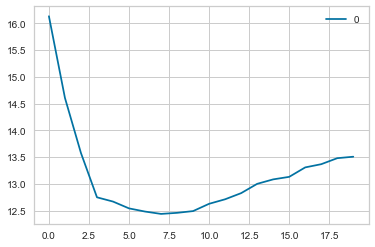

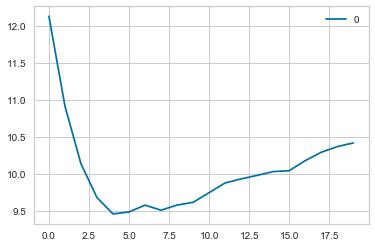

In [86]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

curve2 = pd.DataFrame(mae_val)
curve2.plot()

Why the hell does this graph not match the output from above it...


Going with MAE since its more appropriate for our data set.

In [79]:
# train the model with mostly default settings to see how accurate it is
# choosing k=5 and default settings to run intial model
dfDropped_KNNr = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
dfDropped_KNNr.fit(X_train_scaled, y_train)  # train object

y_hat = dfDropped_KNNr.predict(X_test_scaled) # get test set precitions

error = sqrt(mean_squared_error(y_test,y_hat)) #calculate rmse(y_test,y_hat)
print('Root MSE (1-fold):', error )

######### is there a way to get RMSE for all of the folds???
##errors = cross_val_score(dfDropped_KNNr, X, y, cv=cv_object)
# print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (errors.mean(), errors.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.


Root MSE (1-fold): 12.652825544397711


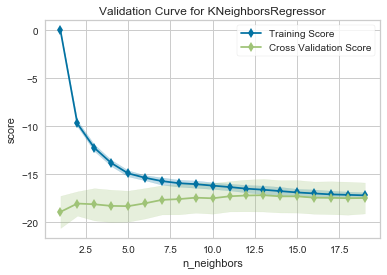

In [156]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='n_neighbors',
    param_range=np.arange(1, 20), cv=cv_object, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

This shows that our error will not get better as the k-nearest neighbors increases past around k=15. Our GridSearchCV can now be refined so save computing time.

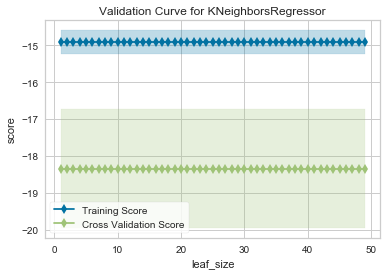

In [90]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='leaf_size',
    param_range=np.arange(1, 50), cv=cv_object, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

This shows that leaf_size has no effect on the error. Values from 1-150 were also visualized with no change. Therefore the default leaf_size will be used (30).

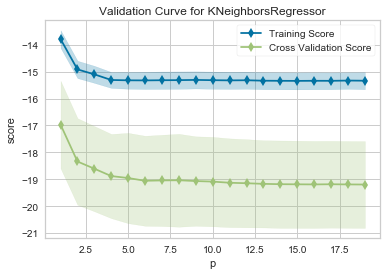

In [93]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='p',
    param_range=np.arange(1, 20), cv=cv_object, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

In [95]:
#source for hyper parameter code: https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

# define the parameter values that should be searched
k_range = list(range(1, 20))

p_range = list(range(1, 6))

# Another parameter besides k that we might vary is the weights parameters
# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)

# we create a list
weight_options = ['uniform', 'distance']

algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']


# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors = k_range, weights = weight_options, 
                  algorithm = algorithm_options, p=p_range)

# instantiate and fit the grid
# exhaustive grid-search because it's trying every combination
# 10-fold cross-validation is being performed 30 x 2 = 60 times

grid = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv = cv_object, 
                    scoring = mae_scorer, n_jobs = -1, verbose = 2)
grid.fit(X_train_scaled, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 10 folds for each of 760 candidates, totalling 7600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1693 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2307 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 4007 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 4824 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 5739 tasks      | elapsed: 22.5min


-8.527177552640833
{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=1,
          weights='distance')


[Parallel(n_jobs=-1)]: Done 7600 out of 7600 | elapsed: 27.1min finished


Now that we have the best parameters we could have for the model we'll use this for the final model using the full data.

In [96]:
gridEstimator = grid.best_estimator_

EvaluateRegressionEstimator(gridEstimator, X, y, cv_object)

The average MAE for all cv folds is: 			 16.179
The average MAE percentage (MAPE) for all cv folds is: 	 28.285
The average RMSE for all cv folds is: 			 22.292
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,15.249487,23.079396,22.330116
1,16.869364,28.324367,22.756217
2,16.920011,30.754694,22.813458
3,17.100491,26.657263,24.976747
4,16.042898,32.318131,22.148099
5,17.206112,27.904434,23.491267
6,15.815090,27.221518,22.046145
7,13.553004,25.550585,18.079444
8,16.490166,27.784629,23.104502
9,16.541567,33.258880,21.177018


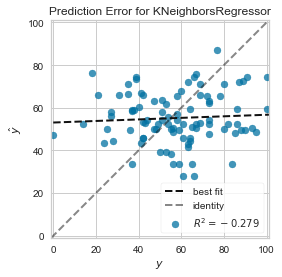

In [127]:
########################3
# don't know if this code is appropriate on how its set up now
from yellowbrick.regressor import PredictionError

KNN = neighbors.KNeighborsRegressor()
visualizer = PredictionError(KNN)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### KNN for % college enrolled

In [111]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'ALL_All Students (Total or Subtotal_ENROLL_sch_pct' in dfDroppedSchPctModels:
    ySchPct = dfDroppedSchPctModels['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].values # get the labels we want
    del dfDroppedSchPctModels['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] # get rid of the class label
    XSchPct = dfDroppedSchPctModels.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(ySchPct)
cv_object2 = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=1)
                         
print(cv_object2)

ShuffleSplit(n_splits=10, random_state=1, test_size=0.2, train_size=None)


In [112]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XSchPct, ySchPct): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    XSchPct_train = XSchPct[train_indices]
    ySchPct_train = ySchPct[train_indices]
    
    XSchPct_test = XSchPct[test_indices]
    ySchPct_test = ySchPct[test_indices]

In [113]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(XSchPct_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

XSchPct_train_scaled = scl_obj.transform(XSchPct_train) # apply to training
XSchPct_test_scaled = scl_obj.transform(XSchPct_test) # apply those means and std to the test set (without snooping at the test set values)

In [114]:
rmse_val = [] #to store rmse values for different k
mae_val = []  #to store mae values for different k
for K in range(20):
    K = K + 1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(XSchPct_train_scaled, ySchPct_train)  #fit the model
    pred = model.predict(XSchPct_test_scaled) #make prediction on test set
    rmse = sqrt(mean_squared_error(ySchPct_test, pred)) #calculate rmse
    mae = mean_absolute_error(ySchPct_test, pred)
    rmse_val.append(rmse) #store rmse values
    mae_val.append(mae) #store mae values
    print('For k =' ,K , 'RMSE: ',rmse, 'MAE: ',mae)

For k = 1 RMSE:  13.050349033076303 MAE:  9.391294485366679
For k = 2 RMSE:  10.909260841950577 MAE:  8.13968719992974
For k = 3 RMSE:  9.884305220759948 MAE:  7.3228228976720375
For k = 4 RMSE:  10.001285595169259 MAE:  7.458454285249324
For k = 5 RMSE:  10.232865150511211 MAE:  7.709769179893921
For k = 6 RMSE:  9.756881897177747 MAE:  7.430331951937078
For k = 7 RMSE:  10.112671114358859 MAE:  7.6741686239379066
For k = 8 RMSE:  10.247406298220668 MAE:  7.793041581157537
For k = 9 RMSE:  10.387148760722683 MAE:  7.796383045776314
For k = 10 RMSE:  10.335678771992617 MAE:  7.771466005442717
For k = 11 RMSE:  10.339855039575122 MAE:  7.687657444574523
For k = 12 RMSE:  10.295125794657876 MAE:  7.639012581738123
For k = 13 RMSE:  10.242798202682872 MAE:  7.535838395903604
For k = 14 RMSE:  10.079886715053846 MAE:  7.536126476700304
For k = 15 RMSE:  10.180391265785296 MAE:  7.55110027070312
For k = 16 RMSE:  10.213937105790064 MAE:  7.528007486185187
For k = 17 RMSE:  10.27887887864565

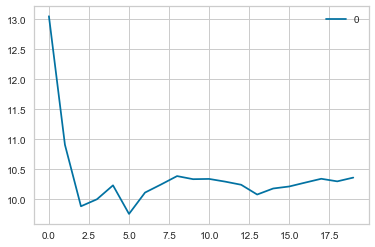

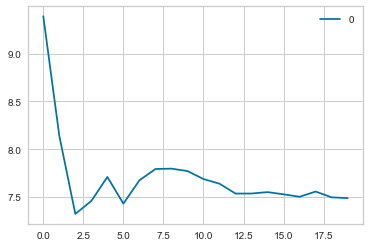

In [115]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

curve2 = pd.DataFrame(mae_val)
curve2.plot()

In [116]:
# train the model with mostly default settings to see how accurate it is
# choosing k=5 and default settings to run intial model
dfDropped_KNNr = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
dfDropped_KNNr.fit(XSchPct_train_scaled, ySchPct_train)  # train object

ySchPct_hat = dfDropped_KNNr.predict(XSchPct_test_scaled) # get test set precitions

errorSchPct = sqrt(mean_squared_error(ySchPct_test, ySchPct_hat)) #calculate rmse(y_test,y_hat)
print('Root MSE (1-fold):', errorSchPct )

######### is there a way to get RMSE for all of the folds???
##errors = cross_val_score(dfDropped_KNNr, X, y, cv=cv_object)
# print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (errors.mean(), errors.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

Root MSE (1-fold): 10.209372584963845


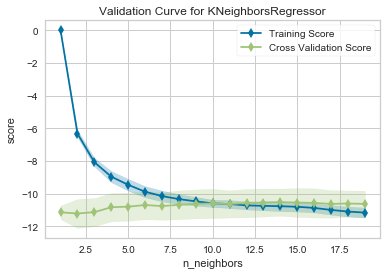

In [119]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='n_neighbors',
    param_range=np.arange(1, 20), cv=cv_object2, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

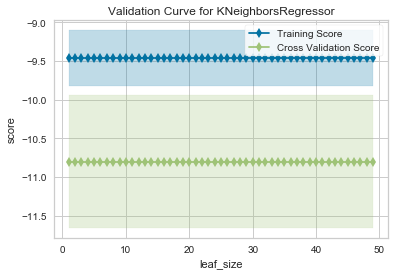

In [120]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='leaf_size',
    param_range=np.arange(1, 50), cv=cv_object2, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

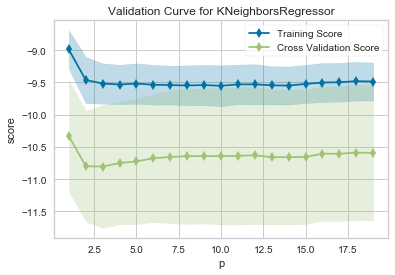

In [121]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='p',
    param_range=np.arange(1, 20), cv=cv_object2, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

In [122]:
#source for hyper parameter code: https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

# define the parameter values that should be searched
k_range = list(range(1, 11))

p_range = list(range(1, 8))

# Another parameter besides k that we might vary is the weights parameters
# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)

# we create a list
weight_options = ['uniform', 'distance']

algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']


# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors = k_range, weights = weight_options, 
                  algorithm = algorithm_options, p=p_range)

# instantiate and fit the grid
# exhaustive grid-search because it's trying every combination
# 10-fold cross-validation is being performed 30 x 2 = 60 times

grid = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv = cv_object2, 
                    scoring = mae_scorer, n_jobs = -1, verbose = 2)
grid.fit(XSchPct_train_scaled, ySchPct_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 167 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1063 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1550 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2189 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2938 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 3670 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 4848 tasks      | elapsed: 21.4min


-9.249308025732597
{'algorithm': 'auto', 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=8, p=1,
          weights='distance')


[Parallel(n_jobs=-1)]: Done 5600 out of 5600 | elapsed: 23.6min finished


In [123]:
gridEstimator2 = grid.best_estimator_

EvaluateRegressionEstimator(gridEstimator2, XSchPct, ySchPct, cv_object2)

The average MAE for all cv folds is: 			 9.8384
The average MAE percentage (MAPE) for all cv folds is: 	 15.831
The average RMSE for all cv folds is: 			 14.631
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,10.064916,15.708195,15.325845
1,10.764988,17.695749,15.505456
2,9.539264,14.075154,15.528156
3,8.956926,15.312376,12.635225
4,9.000223,15.024461,13.585411
5,9.865151,16.286238,15.269097
6,9.452256,16.168808,13.641793
7,9.894388,17.220877,13.498234
8,11.835606,15.508876,17.977149
9,9.010593,15.304640,13.344695


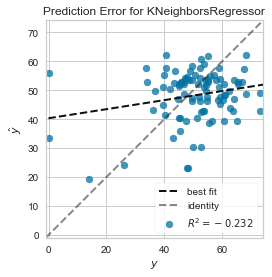

In [126]:
########################3
# don't know if this code is appropriate on how its set up now
from yellowbrick.regressor import PredictionError

KNN = neighbors.KNeighborsRegressor()
visualizer = PredictionError(KNN)

visualizer.fit(XSchPct_train, ySchPct_train)  # Fit the training data to the visualizer
visualizer.score(XSchPct_test, ySchPct_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### MODEL 2: Random Forest??

Now for ACT scores lets use a Random Forest regression model instead of KNN regression. To help narrow the scope of the parameters that need to be hypertuned we'll use yellowbrick to visualize smaller error scores on each parameter.

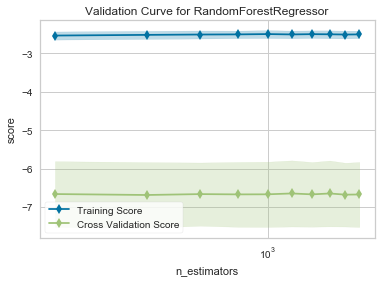

In [141]:
from sklearn.ensemble import RandomForestRegressor

viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
    logx = True, cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

The number of estimaors for the tree have a slighty better score as they increase, this will likely be the parameter that needs the widest range of values when tuning in our GridSearchCV.

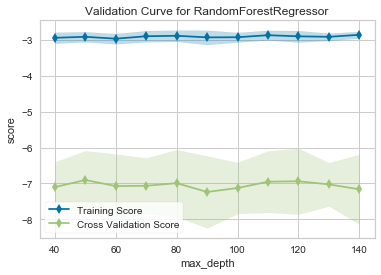

In [146]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

For max depth on our trees in the random forrest it looks like there might be a slightly smaller score in the 80-110 range as compared to the other depths. We'll set our tuning to around this range.

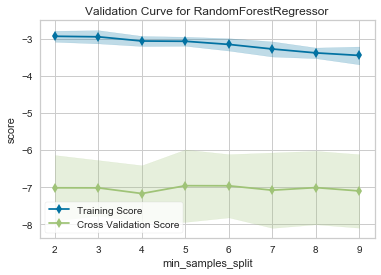

In [144]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

For the minimum samples to split a tree it is clear the smaller the better.

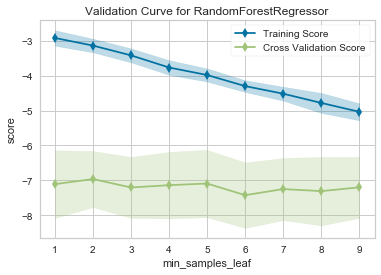

In [145]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

Even more obvious than the minimum samples to split a tree are the minimum samples in a leaf needs to be as small as possible to obtain the most accurate model.

Using the information gathered from the visualizations provided by the yellowbrick package we'll first perform a RandomizedSearchCV which is similar to GridSearchCV to hypertune parameters. But instead of building every model given in the parameter range given out of the entire data set it will subset the data. This is suboptimal but provides enough information to narrow the range of hypertuning needed that can be done in a later GridSearchCV. This was not as necessary in our KNN model because KNN is a much less computationally intensive model, whereas RandomForest must generate many many deceision trees (!!!!!need to revise this last sentence to make it correct rather than just vague!!!)

In [67]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70, 140, num = 8)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 7]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [69]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_randomACT = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv_object, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_randomACT.fit(X_train_scaled, y_train)

# examine the best model
print(rf_randomACT.best_score_)
print(rf_randomACT.best_params_)
print(rf_randomACT.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.9min finished
C:\Users\Clovis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [147]:
# analyze how well the RandomizedGridSearch model predicted

gridRandomEstimatorACT = rf_randomACT.best_estimator_

EvaluateRegressionEstimator(gridRandomEstimatorACT, X, y, cv_object)

NameError: name 'rf_random' is not defined

"From these results, we should be able to narrow the range of values for each hyperparameter."

In [70]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
RFgrid_searchACT = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
RFgrid_searchACT.fit(X_train_scaled, y_train)

# examine the best model
print(RFgrid_searchACT.best_score_)
print(RFgrid_searchACT.best_params_)
print(RFgrid_searchACT.best_estimator_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 76.4min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 77.2min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1400}

In [71]:
# analyze how well the GridSearchCV model based on RandomizedGridSearchCV predicted

grid_RF_Estimator = grid_search.best_estimator_

EvaluateRegressionEstimator(grid_RF_Estimator, X, y, cv_object)

NameError: name 'evaluate' is not defined

In [ ]:
########################3
# don't know if this code is appropriate on how its set up now
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### RF for % enrolled

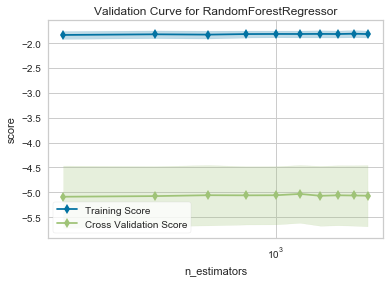

In [148]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
    logx = True, cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

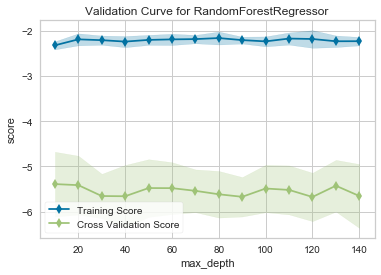

In [149]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(10, 140, num = 14)], 
    cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

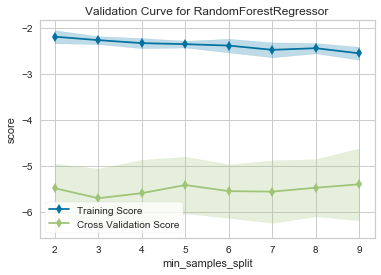

In [150]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

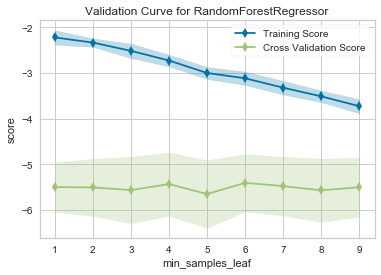

In [151]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(80, 140, num = 7)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid2 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid2)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_randomSchPct = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv_object2, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_randomSchPct.fit(XSchPct_train_scaled, ySchPct_train)

# examine the best model
print(rf_randomSchPct.best_score_)
print(rf_randomSchPct.best_params_)
print(rf_randomSchPct.best_estimator_)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
RFgrid_searchSchPct = GridSearchCV(estimator = rf, param_grid = param_grid, cv = cv_object2, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
RFgrid_searchSchPct.fit(XSchPct_train_scaled, ySchPct_train)

# examine the best model
print(RFgrid_searchSchPct.best_score_)
print(RFgrid_searchSchPct.best_params_)
print(RFgrid_searchSchPct.best_estimator_)

In [ ]:
# analyze how well the GridSearchCV model based on RandomizedGridSearchCV predicted

grid_RF_Estimator_SchPct = grid_search.best_estimator_

EvaluateRegressionEstimator(grid_RF_Estimator_SchPct, XSchPct, ySchPct, cv_object2)

In [ ]:
########################
# don't know if this code is appropriate on how its set up now
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(rf)

visualizer.fit(XSchPct_train, ySchPct_train)  # Fit the training data to the visualizer
visualizer.score(XSchPct_test, ySchPct_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### MODEL 3: SVM?? LINEAR REGRESSION?

<a href="#top">Back to Top</a> 
<a id="Model4"></a>
### Modeling and Evaluation 4

<span style="color: blue">Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</span>

<a href="#top">Back to Top</a> 
<a id="Model5"></a>
### Modeling and Evaluation 5

<span style="color: blue">Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.</span>

#### KNN



#### Random Forest
- one of most powerful machine learning algorithms, still rivals any classification method
- guaranteed to perform well because of extremely low bias
- can add more trees, little to no risk of overlearning or overfitting because of randomness, provided the test set is representative of the overall data set
- generate internal unbiased estimate of generalization error
- have effective methods to estimate missing data
- can have thousands of input variables

<a href="#top">Back to Top</a> 
<a id="Model6"></a>
### Modeling and Evaluation 6

<span style="color: blue">Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</span>

<a href="#top">Back to Top</a> 
<a id="Deployment"></a>
## Deployment

<span style="color: blue">How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? </span>

<a href="#top">Back to Top</a> 
<a id="Exceptional"></a>
## Exceptional Work

<span style="color: blue">You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</span>

# ### BELOW IS FROM MINI-LAB NOTEBOOK ###

There are 403 columns in our dataset. We dropped any columns that have zero variance and only dropped one column. We also wanted to remove highly correlated variables to reduce multi-collinearity. For a Pearson R threshold of 0.8, we removed any variables where the `r` value was greater than `0.8`. As a result, we dropped 124 highly correlated variables in the code blocks below. We used the dropped columns dataset to build our logistic regression model and for our initial SVM model to compare the performance between the two models. We will talk about the model performance later on in our notebook.

In [5]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [6]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [7]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print("Columns dropped: {}".format(len(to_drop)))

Columns dropped: 124


We performed some data preparation before running our logistic regression and SVM models. Since our target variable is a continuous variable, we needed to split the target variable evenly into a binary response so our data was split at the median. We created a new variable called `schoolPctTarget` and assigned a value of `1` to schools with students enrolled in a postsecondary institution greater or equal to the median value (52.18%) and `0` to schools with less than the median value of 52.18%.

It is important to create a split dataset so we do not train a model that is better at classifying one side than the other therefore, we want our model to be trained on both binary values. 

In [8]:
# Split the target variable based on the median value
medianSplit = dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()

dfDropped['schoolPctTarget'] = np.where(dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= medianSplit, 1, 0)

print("Median: {}".format(medianSplit))
print("{} of {}: {}%".format(dfDropped['schoolPctTarget'].sum(), dfDropped.shape[0], 
                             round(dfDropped['schoolPctTarget'].sum()/dfDropped.shape[0] * 100,2)))

Median: 52.178614549748545
235 of 470: 50.0%


### Column preparation

At this point, the dataset contains 'future' information that the model should not be aware of. We need to drop these columns before we build the model. In addition, some of the column names don't start with alpha characters which cause code later in the notebook to miss these columns and not graph the most significant support vectors correctly

In [9]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfDropped.filter(regex = r'sch_pct')

dfDropped.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfDropped.columns = dfDropped.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfDropped.columns = dfDropped.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfDropped.rename(columns=renameCols, inplace = True)

In [10]:
y = dfDropped['schoolPctTarget']

In [11]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 42)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None)


In [12]:
maxCols = dfDropped.shape[1]
X = dfDropped.iloc[:,0:maxCols-2]

### Data split
Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [13]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2, random_state = 42)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

Store these variables for us later in the SVM model

In [14]:
xTrainLR = xTrain
xTestLR = xTest
yTrainLR = yTrain
yTestLR = yTest

<a id = "LR"></a>
## Logistic Regression

In [15]:
#First model will use Lasso (Least Absolute Shrinkage and Selection Operator) regression which adds a penalty term to the coefficients to shrink the less important ones to zero. Thereby helping with further feature selection. Through trial and error the first cost penalty (C) we will use a cost of 1.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[26 14]
 [17 37]]
Accuracy (1-Fold) 0.6702127659574468
Accuracy (10-Fold): 0.67 (+/- 0.08)


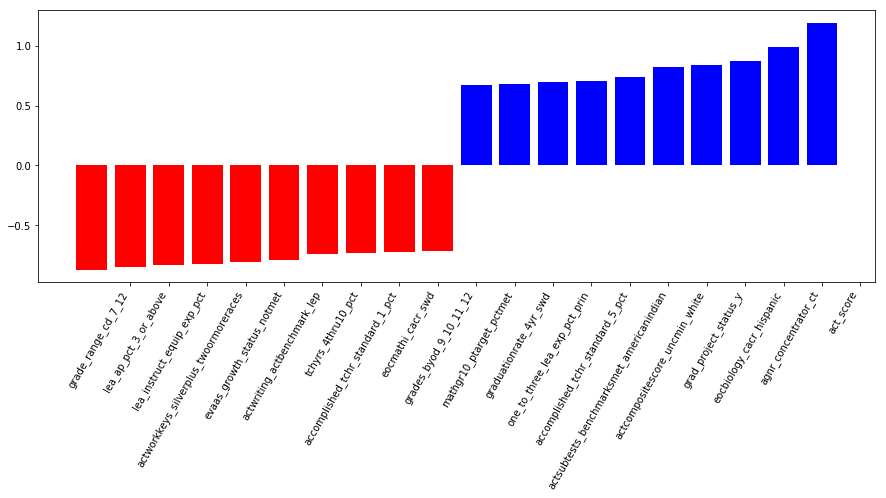

In [16]:
# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [17]:
#The second model uses Lasso regression but changes the cost to 0.05.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=0.05, class_weight=None, random_state=2) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[27 13]
 [11 43]]
Accuracy (1-Fold) 0.7446808510638298
Accuracy (10-Fold): 0.70 (+/- 0.09)


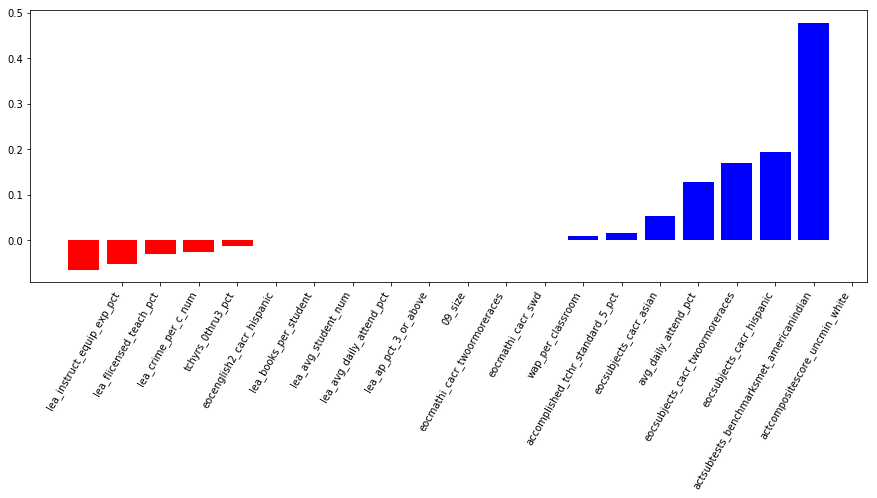

In [18]:
plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [19]:
#Our third model will use Ridge regression which also adds a different penalty term. Through trial and error the first cost penalty (C) we will use a cost of 1.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 42))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[27 13]
 [20 34]]
Accuracy (1-Fold) 0.648936170212766
Accuracy (10-Fold): 0.68 (+/- 1.47)


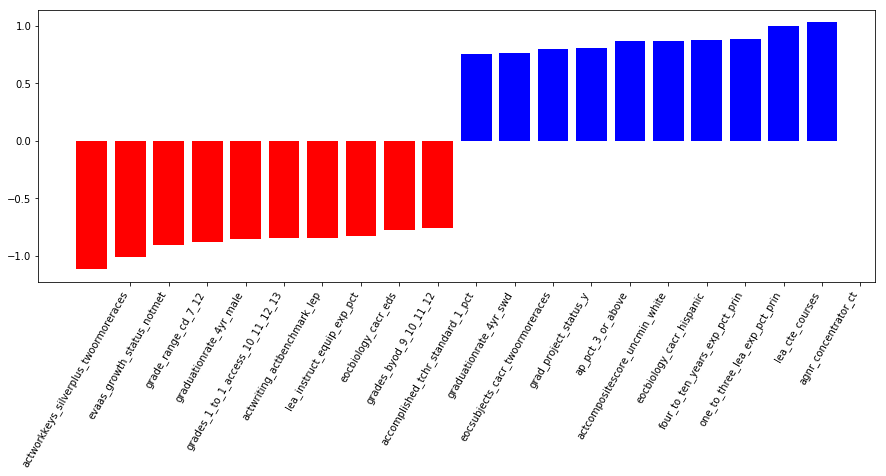

In [20]:
plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [21]:
#The fourth model uses Ridge regression but changes the cost to 0.05.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[29 11]
 [14 40]]
Accuracy (1-Fold) 0.7340425531914894
Accuracy (10-Fold): 0.68 (+/- 0.09)


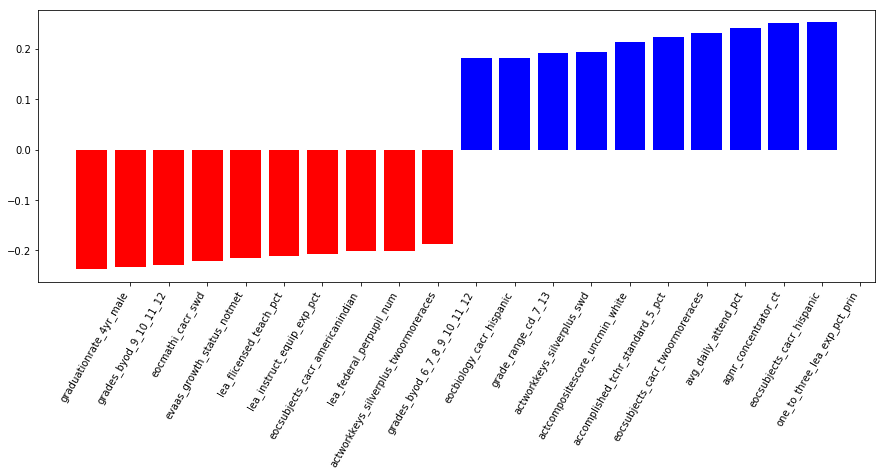

In [22]:
# Graph the columns in terms of prediction weight
#cv = CountVectorizer()
#cv.fit(XCopy)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features = 10)

<a id="SVM"></a>
## Support Vector Machines

### Linear Regression Features
For comparison against the two models, build a model with the attributes used for the linear regression model

In [23]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

Train the model and determine the best parameter to use for our model

In [24]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrainLR, yTrainLR)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 00:51:32.693125
Wall time: 2.48 s
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.699 (+/-0.108) for {'C': 1}
0.697 (+/-0.095) for {'C': 10}
0.697 (+/-0.100) for {'C': 100}
0.697 (+/-0.100) for {'C': 1000}



Using the best parameter, we build our model and then test it against the data

In [25]:
# Set model to best values found
cls = SVC(C = bestValues['C'], kernel = 'linear')

# Train
cls.fit(xTrainLR, yTrainLR)

# Predict test values
yhat = cls.predict(xTestLR)

# Show model performance
print("Accuracy Value:\n {}".format(accuracy_score(yTest,y_hat)))
print("Confusion Matrix:\n {}".format(confusion_matrix(yTest, yhat)))
print("Classification Report:\n {}".format(classification_report(yTest, yhat)))

Accuracy Value:
 0.7340425531914894
Confusion Matrix:
 [[26 14]
 [23 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.65      0.58        40
           1       0.69      0.57      0.63        54

   micro avg       0.61      0.61      0.61        94
   macro avg       0.61      0.61      0.61        94
weighted avg       0.62      0.61      0.61        94



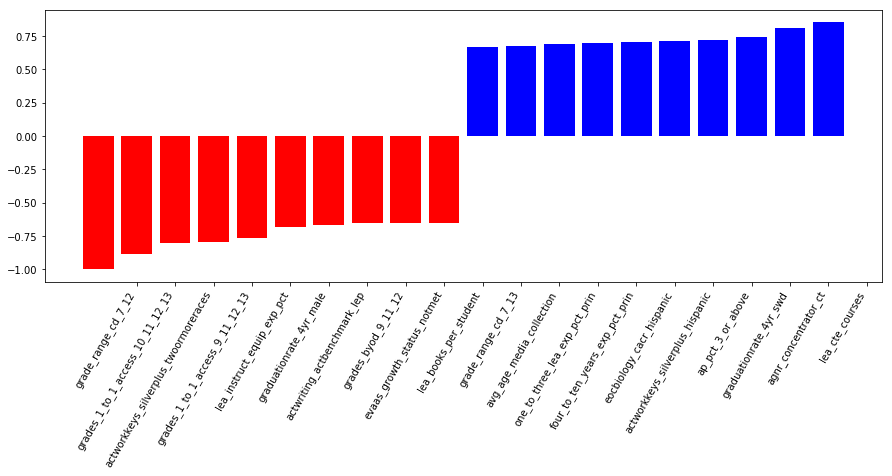

In [26]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

### ANOVA Feature Selection
Using the ANOVA F-value to determine which columns have the greatest proportion of variance, we select the top 10% to be used in our model. The F-value tells us which column(s) help to explain the greatest amount of variance in the target variable. The columns with the highest proportion allows the model to solve for the greatest separation on attributes for classification.

In [27]:
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct')

dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Subset the data to exclude the target variable
maxCols = dfPublicHS.shape[1]
X = dfPublicHS.iloc[:,0:maxCols-2]

# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [28]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2, random_state = 42)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

Here we create a range of values to test the model against to determine which parameters provide the best result.

In [29]:
# Set parameter turning values and create a grid of models to run
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=[1,10,100,1000])

gridRBF = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

Run the models and show results

In [30]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
%time gridRBF.fit(xTrain, yTrain)

bestValues = gridRBF.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridRBF scores on development set:")
print()
means = gridRBF.cv_results_['mean_test_score']
stds = gridRBF.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridRBF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 00:51:53.230387
Wall time: 9.16 s
Best parameters set found on development set:

{'C': 1, 'gamma': 0.001}

gridRBF scores on development set:

0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-09}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-08}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-07}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-06}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-05}
0.663 (+/-0.118) for {'C': 1, 'gamma': 0.0001}
0.694 (+/-0.136) for {'C': 1, 'gamma': 0.001}
0.686 (+/-0.086) for {'C': 1, 'gamma': 0.01}
0.659 (+/-0.164) for {'C': 1, 'gamma': 0.1}
0.583 (+/-0.080) for {'C': 1, 'gamma': 1.0}
0.519 (+/-0.013) for {'C': 1, 'gamma': 10.0}
0.519 (+/-0.013) for {'C': 1, 'gamma': 100.0}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1000.0}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-09}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-08}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-07}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-06}
0.663 (+/-0.118) for {'C': 10, 'gamma': 1e-05}
0.681 (

Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [31]:
# Set model to best values found
cls = SVC(C = bestValues['C'], gamma = bestValues['gamma'])

# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
# Show model performance
print("Accuracy Value:\n {}".format(accuracy_score(yTest,y_hat)))
print("Confusion Matrix:\n {}".format(confusion_matrix(yTest, yhat)))
print("Classification Report:\n {}".format(classification_report(yTest, yhat)))

Accuracy Value:
 0.7340425531914894
Confusion Matrix:
 [[28 12]
 [15 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.67        40
           1       0.76      0.72      0.74        54

   micro avg       0.71      0.71      0.71        94
   macro avg       0.71      0.71      0.71        94
weighted avg       0.72      0.71      0.71        94



Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

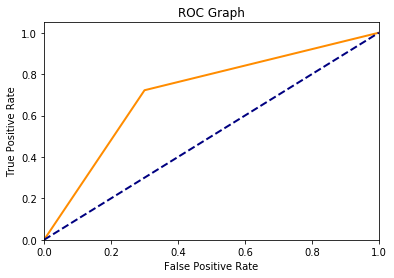

In [32]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

Here we create a range of values to test the model against to determine which parameters provide the best result.

In [33]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [34]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrain, yTrain)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 00:52:09.106832
Wall time: 747 ms
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.678 (+/-0.082) for {'C': 1}
0.632 (+/-0.151) for {'C': 10}
0.632 (+/-0.183) for {'C': 100}
0.592 (+/-0.202) for {'C': 1000}



Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [35]:
cls = SVC(C = bestValues['C'], kernel = 'linear')

<a href="#top">Back to Top</a>
<a id="Model"></a>
## Model Advantages (10 points)

Logistic regression and support vector machine (SVM) are both classification models and rely on differently constructed algorithms. Selecting an optimal model depends on the question at hand and the dataset with which one is working. In general terms, there are advantages and limitations to both, which should be considered when designing analysis.

#### Logistic Regression

Logistic regression is a model that describes probability (or population proportion) as a function of explanatory variables, where the and interpretations of regression coefficients are made in terms of statements about odds and odds ratios. Advantages of logistic regression are that it tends to be robust to small noise in a dataset and is not affected by mild cases of multi-collinearity (where redundant, strongly correlated variables impact results in a model).

Limitations to be mindful of when working with logistic regression include being aware of overfitting the model, the presence of a large number of features (feature space) or instances of missing data, and datasets containing a large number of categorical variables. These, of course, can be addressed in the data preparation phase of analysis as well as in the parameters of the actual models. For example, weight parameters can be used to help control overfitting. 

#### Support Vector Machine

As Dr. Larson noted in the class videos, SVM is “arguably one of the most exciting topics you will see in machine learning.” It is a classification technique, with “roots in statistical learning theory,” that works to find a decision boundary that divides the data into classes. Advantages of this versatile model are that it works for both linear and non-linear decision boundaries and handle a large feature space. However, since it is more complex than simply creating a line, the algorithm can be much slower to train data than other techniques.  

An important SVM concept is the maximal margin hyperplane, or the maximum margin, which will yield the optimal decision boundary. A boundary with large margins tends to have better generalization errors; a boundary with small margins tend to overfit and perform poorly on test or new data. When defining the SVM algorithm, one needs to decide on the cost parameter. Low cost allows for a wide margin and a higher number of errors, where high costs allows for narrower margins and lower errors. 


#### Model Performance

Working the North Carolina attainment data set, the team built logistic regression and SVM models to predict if approximately 52% or more students at a school enrolled in post-secondary education after graduation. We used the 2017 high school machine learning data set (PublicHighSchool2017_ML from https://github.com/jakemdrew/EducationDataNC).

*Data Perparation*
In order to build the models, the team took several steps to prepare, cull, and scale the data, which included: removing variables with 0 variance (1 column) and removing variables with a Pearson correlation greater than 80% (reduced data by about 30.77% or 124 columns); this helped to temper multi-collinearity and overfitting. Additionally, we encoded our response variable - % of student enrolling in post-secondary education - to a binary field and removed variables about enrollemnt from the data set, as to not use enrollment data in building the models. Finally, we split the data by 80% training and 20% test and scaled the data using the mean and standard deviation of the training data set. 


*Logistic Regression Performance*

| LR SUMMARY | Penalty | Cost | Accuracy | Two Std Dev |
|------------|------------|------|----------|-------------|
| LR Model 1 | L1 - Lasso | 1 | 0.67 | +/- 0.08 |
| LR Model 2 | L1 - Lasso | 0.05 | 0.70 | +/- 0.09 |
| LR Model 3 | L2 - Ridge | 1 | 0.68 | +/- 0.07 |
| LR Model 4 | L2 - Ridge | 0.05 | 0.68 | +/- 0.09 |


Overall, the Logistic Regression models performed similarly as noted above. The model with Lasso Regression and a low-cost value of 0.05 had the highest accuracy but also had the largest variation. The models all ran with similar times, so there is no perceptible difference in terms of training time or efficiency within the Logistic Regression set up. Given the size of our data set, we did not have to use Stochastic Gradient Descent to optimize the Logistic Regression models.

#### SVM Performance

The SVM models were built on two data sets using two different kernels to create the decision boundaries. The two data sets used were named: Correlation, where we reduced the variables using the same methods in the Logistic Regression data based on 80% or greater Pearson value; and ANOVA, where feature selection was employed to determine the top 10% of variables based on the proportion of variance explained by the features (or groups of features).

| SVM Summary | Data Set | Accuracy | Precision | Recall | F1-Score |
|---------------------|-------------|------|-----------|--------|----------|
| Linear Kernel Model | Correlation | 0.73 | 0.62 | 0.61 | 0.61 |
| Linear Kernel Model | ANOVA | 0.74 | 0.74 | 0.74 | 0.74 |
| RBF Kernel Model | ANOVA | 0.71 | 0.72 | 0.71 | 0.71 |

The SVM Linear Kernel Model, using the data set reduced by ANOVA methods, performed the best of the three models. The models all ran with similar times - in under about under a minute - so there is no perceptible difference in terms of training time or efficiency within the SVM set up. As noted above, we did not have to use Stochastic Gradient Descent to optimize the models. 

Definitions:
-	Precision: ratio of true positives / true positives + false positives; ability of the model to not label a sample as positive when it is negative.
-	Recall: The recall is the ratio true positive / true positives + false negatives; ability of the model to find all the positive samples.
-	F1-Score: a weighted harmonic mean of the precision and recall, where an F1-score reaches its best value at 1 and worst score at 0.

#### Comparative Performance

Overall, the SVM models performed slightly better than the Logistic Regression models, but not by a significant margin, and performing better than chance. We were able to get an average accuracy around 70% for both models. Due to the number of instances and attributes, the models were very similar in speed for calculating the coefficient weights. The number of parameters that could be adjusted within SVM allows for more permutations to be tested to find the best model, increasing the time to determine the best parameters.

Citation: 
https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/

Ramsey, F. L., and Schafer, D. W. (2013), The Statistical Sleuth: A
Course in Methods of Data Analysis (3rd ed.), Boston, MA: Brooks/Cole.

Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

In [36]:
# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
print("Accuracy Value:\n {}".format(accuracy_score(yTest,y_hat)))
print("Confusion Matrix:\n {}".format(confusion_matrix(yTest, yhat)))
print("Classification Report:\n {}".format(classification_report(yTest, yhat)))

Accuracy Value:
 0.7340425531914894
Confusion Matrix:
 [[27 13]
 [11 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69        40
           1       0.77      0.80      0.78        54

   micro avg       0.74      0.74      0.74        94
   macro avg       0.74      0.74      0.74        94
weighted avg       0.74      0.74      0.74        94



Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

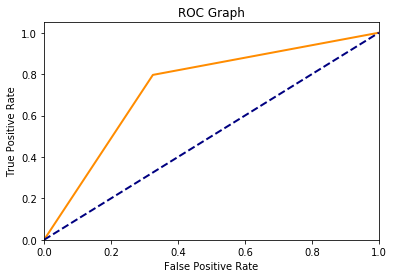

In [37]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

### Most influential Support Vectors
The graph below helps us determine which attributes have the most impact on the boundary between support vectors. This gives us some indication of what attributes might help increase the number of students enrolled in postsecondary education.

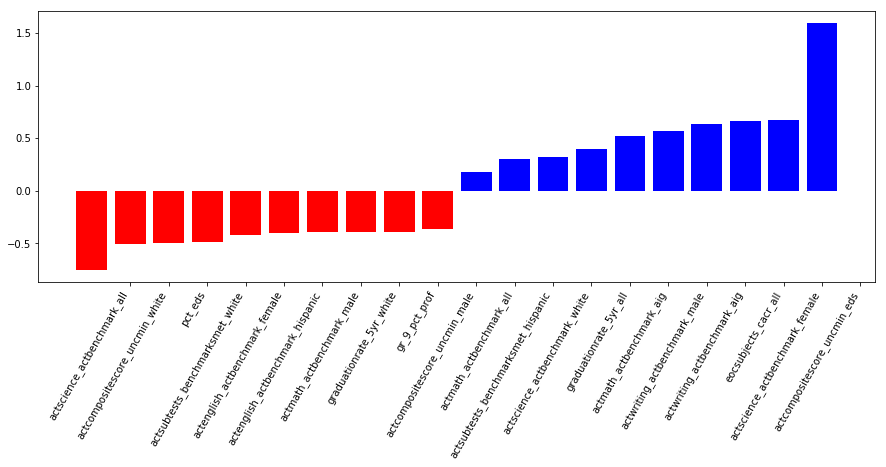

In [38]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

<a href="#top">Back to Top</a>
<a id="Interpret"></a>
## Interpret Feature Importance (30 points)

| Attribute | Description | Weight | Odds Ratio |
|------------------------------------|-----------------------------------------------------------------------------------------------------------------|--------|------------|
| pct_eds | % of Economically disadvantaged students | -0.065 | 0.937 |
| TwoOrMoreMalePct | % of male students identifying with 2 or more demographics | -0.051 | 0.949 |
| HispanicMalePct | % of Hispanic Male students | -0.031 | 0.970 |
| grades_1_to_1_access_9:10:11 | Description Unavailable | -0.026 | 0.974 |
| GraduationRate_4yr_LEP | 4-year graduation rate for Limited English Proficiency | -0.012 | 0.987 |
| Math_I_Size | State Math Score | 0.009 | 1.01 |
| ACTCompositeScore_UNCMin_AIG | ACT composite score with University of North Carolina standards for Academically/Intellectually Gifted students | 0.015 | 1.01 |
| ACTSubtests_BenchmarksMet_Hispanic | ACT subtest scores meeting benchmarks for Hispanic students | 0.054 | 1.06 |
| EOCMathI_CACR_AIG | End of Course Math 1 scores for College and Career Ready Academically/Intellectually Gifted students | 0.128 | 1.137 |
| ACTWorkKeys_SilverPlus_AIG | ACT Work Keys scores (10th grade) at Silver or Gold benchmark for Academically/Intellectually Gifted students | 0.169 | 1.185 |
| GraduationRate_5yr_All | 5-year Graduation Rate of all students | 0.193 | 1.213 |
| ACT_Score | Score on ACT | 0.478 | 1.613 |


The explanatory variables that were found to be significant and have a negative impact on the percent of students who enroll in college in decreasing absolute value of odds ratio are:

*pct_eds, 0.93705924*<br>
An increase in percent of economically disadvantaged students decreases the odds of those students at that school from enrolling in college post high school. This can be explained in multiple ways. Students’ families who have less income cannot afford luxuries that other students might have. Examples could be an internet connection, tutors, books, a computer, etc. As we’ll see the most important aspect to increase ones odds at enrolling in college is an ACT score, so these students likely cannot afford to take classes that would help boost their score.

*TwoOrMoreMalePct, 0.949613627* <br>
As the percent of male students who identify as two or more demographics increases at a school, the lower the percent of the student body who enrolls in college. This can be interpreted as the increase in minority (more specifically biracial here) children the less likely the students will enroll in college.

*HispanicMalePct, 0.969924269* <br>
Similarly to the increase in biracial male students, the increase in percent of Hispanic male students at a school will decrease the schools percent in students who enroll in college.

*GraduationRate_4yr_LEP, 0.987716081* <br>
The weakest of the negative weights is the four year graduation rate for limited English proficiency students. Graduation rates of any kind would of course be negatively correlated the percentage of students who enroll in college. This also ties in with the previous negative weight of Hispanic male percentage in the student body population.<br><br>
It is a clear consistent theme from our model that the schools with student bodies who have a higher percentage of Hispanics and biracial males, students who have limited English proficiency, and are economically disadvantaged are the biggest detriments to a schools percentage of students who enroll in college. This of course is not to say that their ethnicity is the cause of the lack of college enrollment at a school. But correlations can likely be found between the negative weighted attributes of poverty and high minorities at a high school.

The explanatory variables that were found to be significant and have a positive impact on the percent of students who enroll in college in increasing absolute value of odds ratio are:

*Math_I_Size, 1.009298017*<br>
This refers to just the general state math score. An increase in a student’s math score would correspond to a higher likelihood of them enrolling in college. Along with ACT scores, these are the only repeating attributes that positively effect a student’s odds of enrolling in college post graduating when increased.

*ACTCompositeScore_UNCMin_AIG, 1.015139594*<br>
For ACT composite scores that met and exceeded the standards set by the University of North Carolina for academically/intellectually gifted student, their odds in enrolling in college would increase. This makes sense due to if you were able to acquire an ACT score so high that you would meet the high criteria set for UNC that you would be able to enroll there or elsewhere.

*ACTSubtests_BenchmarksMet_Hispanic, 1.055001217*<br>
For ACT scores that met and exceeded the benchmark for Hispanic students the likelihood of a student enrolling in college after graduation would increase.

*EOCMathI_CACR_AIG, 1.136777066*<br>
For the students that were academically/intellectually gifted the increase in their end of course math 1 scores would increase the likelihood of them enrolling in college post-graduation.

*ACTWorkKeys_SilverPlus_AIG, 1.184900637*<br>
For the students that were academically/intellectually gifted the increase in their Work Key score will increase their odds of enrolling in college.

*GraduationRate_5yr_All, 1.21301939*<br>
Tracking the graduation rate from 9-12 over a four year and five year period. This metric measures the graduation rate of students at schools over a five year span. This would coincide with an increase in the percent of a student enrolling in college because an increase in this metric would mean more students graduated high school. Therefore, if you at least graduated from high school on time the odds of you enrolling in college are much more likely than if you did not graduate.

*ACT_Score, 1.613285839*<br>
The positive impact of a higher ACT score for the increased odds of a student enrolling in college after high school is obvious for that the test is used to help rank applicants in their college enrollment process. It’s also of note that students in North Carolina are required to take the ACT in 11th grade (junior year) so the test should be uniformly taken across all schools/districts across the state.<br>

By far and away the highest impact an attribute can have on increasing the percentage of students who enroll in college 18 months after graduating from high school is their ACT score. Its odds ratio (1.613) is 133% of the next highest odds ratio (5 year graduation rate, 1.213). Since the ACT and SAT are staples of the college enrollment process this would make sense that such a direct attribute in the application process would weigh so heavily on a student enrolling in our model. Three other attributes in our model are subsets of attributes of the ACT score, that’s how heavily this is weighed. If our data was pared down even more to only include the attribute ACT score, it would very likely increase the weight and odds ratio of this attribute even more. This has no doubt been studied before and would lend credence to the widespread business of SAT and ACT classes that sell the promise of increased scores so their students have an increased likelihood of enrolling in college at all, or to more prestigious ones.

<a href="#top">Back to Top</a>
<a id="Support"></a>
## Interpret Support Vectors (10 points)

The best performing SVM model was the third model which used a linear kernel and the ANOVA feature selection attributes to predict if a school would have 52% postsecondary enrollment. An RBF non-linear kernel was examined but did not perform better than the linear model. The weights represent the hyperplane for that attribute where it thinks the best boundary for classification belongs. By taking the dot product of an instance with that vector, one can determine which side of the decision boundary it lies. The higher the value of the coefficient suggests a higher level of importance on being able to classify an instance. [1] The main support vectors all center around the performance of the students on the ACT. The ACT attributes were strong indicators of the resulting classification result. The ACTCompositeScore_UNCMin_Female variable has the highest weight out of all of the variables in our SVM model. The second highest weight is Gr_9_Pct_Prof. These two variables have the most influence on our model being able to correctly classify the instance. This is to be expected since NC public schools require all first time grade 11 students to take the test. [2] In addition, many colleges use these scores to select which students are admitted to the University so it strongly influences whether a student is accepted into college or not. The different demographics associated with the individual columns suggest there is some correlation between how the demographics of a school impact its postsecondary enrollment rate. This would require further analysis to determine the impact of the demographics on the model.

Citations: 
[1] https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights
[2] http://www.ncpublicschools.org/docs/accountability/policyoperations/2017/1718-actfaq.pdf)